In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efootball.src.classes.models.narya_field_homography.KeypointDetectorModel import KeypointDetectorModel
from efootball.src.classes.models.detectron2_person.ModelPerson import PersonDetector 
from efootball.src.classes.models.narya_field_homography.utils.image import denormalize
from efootball.src.classes.models.narya_field_homography.utils.visualization import visualize, rgb_template_to_coord_conv_template, merge_template
from efootball.src.classes.models.narya_field_homography.utils.masks import points_from_mask
from efootball.src.classes.models.narya_field_homography.utils.homography import get_perspective_transform, warp_image
from efootball.src.constants.models import NARYA_KEYPOINT_DETECTOR, NARYA_WEIGTHS_NAME, NARYA_WEIGHTS_TOTAR

from efootball.src.utils.players import define_player_centroid
from efootball.src.utils.geometry import define_center_point

Segmentation Models: using `keras` framework.


c:\Users\ferna\anaconda3\envs\efootball\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
person_detector = PersonDetector(0.6)

In [3]:
field_image = cv2.imread('C:/Users/ferna/OneDrive/Documentos/Insper/Efootball/data/frames/90.png')
field_image = cv2.cvtColor(field_image, cv2.COLOR_BGR2RGB)
image_with_persons = field_image.copy()
field_image = cv2.resize(field_image, (320, 320))
points_field_image = field_image.copy()

In [6]:
persons_locations = person_detector.detectPersons(image_with_persons)

In [7]:
persons_locations

{'boxes': Boxes(tensor([[1590.1602,  661.0518, 1615.2410,  727.1664],
         [1016.6469,  377.7571, 1035.6892,  422.4894],
         [ 851.6904,  527.3949,  881.4066,  593.4481],
         [ 890.1956,  426.5380,  913.4593,  479.4573],
         [1469.7096,  670.1507, 1504.0212,  738.0846],
         [ 772.8768,  690.8762,  801.5240,  761.3420],
         [ 830.0464,  463.6838,  852.9484,  512.5508],
         [1199.8484,  745.5240, 1227.9763,  820.6465],
         [1524.3396,  521.6015, 1563.8107,  581.6144],
         [1066.6931,  989.2463, 1104.1412, 1071.4834],
         [1275.5323,  350.4040, 1292.5122,  394.6766],
         [1254.8174,  702.1140, 1290.1742,  771.2817],
         [1735.2098,  731.4596, 1776.1444,  806.8062],
         [ 122.8554,  489.9155,  141.1428,  527.7030],
         [1200.8848,  569.2660, 1232.5513,  633.2203],
         [1185.6084,  355.3025, 1202.1362,  391.7743],
         [1387.9048,  444.9989, 1416.4532,  496.8381],
         [ 933.6870,  619.9436,  963.9066,  679.08

In [5]:
tx = image_with_persons.shape[0]/320
ty = image_with_persons.shape[1]/320
persons_points = list()
i = 0
for mask, label in zip(np.asarray(persons_locations["masks"].to("cpu")), persons_locations['labels']):
    if label == 0:
        box_person, player_color = define_player_centroid(image_with_persons, mask)
        point = np.array([box_person[2]/ty, box_person[0]/tx])
        persons_points.append(point)
        cv2.putText(points_field_image, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255,0,0), 1)
        i += 1

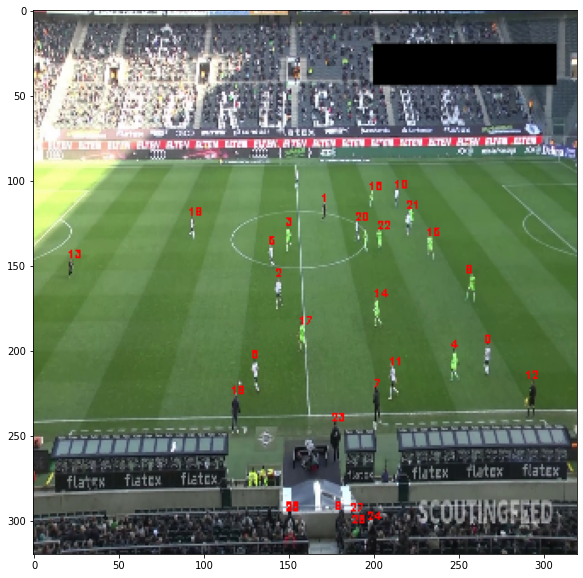

In [6]:
plt.figure(figsize=(20, 10))
plt.imshow(points_field_image)
plt.show()

In [7]:
kp_model = KeypointDetectorModel(backbone='efficientnetb3', num_classes=29, input_shape=(320, 320))
checkpoints = tf.keras.utils.get_file(NARYA_WEIGTHS_NAME, NARYA_KEYPOINT_DETECTOR, NARYA_WEIGHTS_TOTAR)
kp_model.load_weights(checkpoints)
pr_mask = kp_model(field_image)

Succesfully loaded weights from C:\Users\ferna\.keras\datasets\keypoint_detector.h5


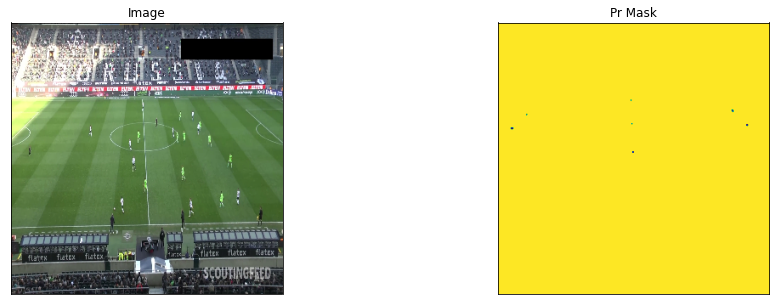

In [8]:
visualize(image=denormalize(field_image.squeeze()),pr_mask=pr_mask[..., -1].squeeze())

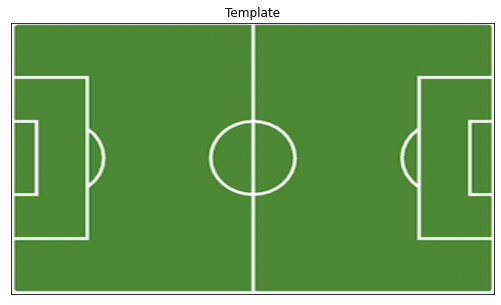

In [9]:
template = cv2.imread('C:/Users/ferna/OneDrive/Documentos/Insper/Efootball/efootball/src/img/football_field.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.
visualize(template=template)

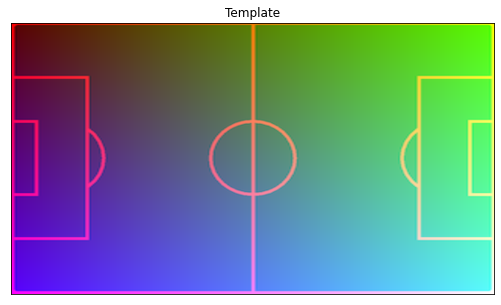

In [10]:
template = rgb_template_to_coord_conv_template(template)
visualize(template=template)

In [11]:
src,dst = points_from_mask(pr_mask[0])
pred_homo = get_perspective_transform(dst,src)
pred_warp = warp_image(cv2.resize(template, (320,320)),pred_homo,out_shape=(320,320))

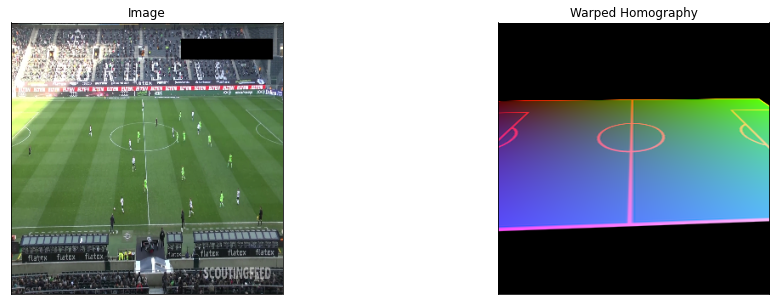

In [12]:
visualize(
        image=denormalize(field_image.squeeze()),
        warped_homography=pred_warp,
    )

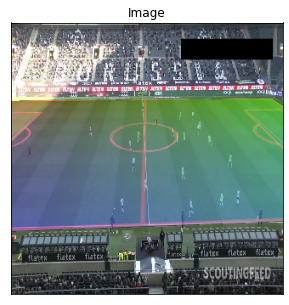

In [13]:
test = merge_template(field_image/255.,cv2.resize(pred_warp, (320, 320)))
visualize(image = test)

In [14]:
inverted_pred_homo = np.linalg.inv(pred_homo)
person_points_test = np.array(persons_points)
person_points_test = person_points_test.astype(np.float32)
pt_transformed = cv2.perspectiveTransform(person_points_test.reshape(-1, 1, 2), inverted_pred_homo)
perspective_transformed = pt_transformed.reshape(-1, 2)

In [15]:
resize_template = cv2.resize(template, (320, 320))

In [16]:
#draw points on template with a number
resize_template2 = resize_template.copy()
for i, point in enumerate(perspective_transformed):
    cv2.putText(resize_template2, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,0), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


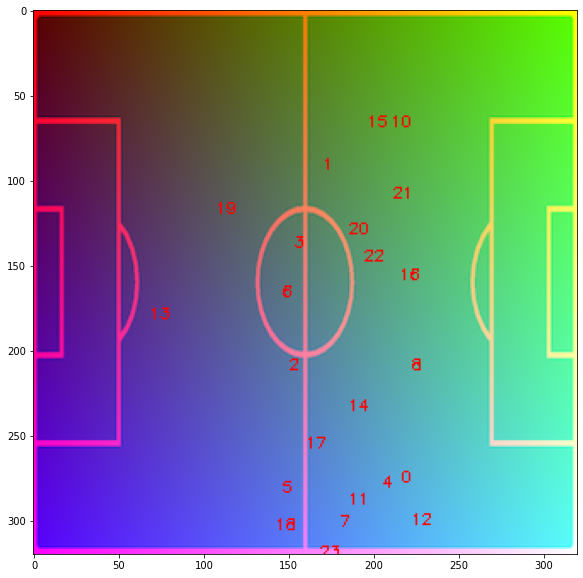

In [17]:
plt.figure(figsize=(20, 10))
plt.imshow(resize_template2)
plt.show()

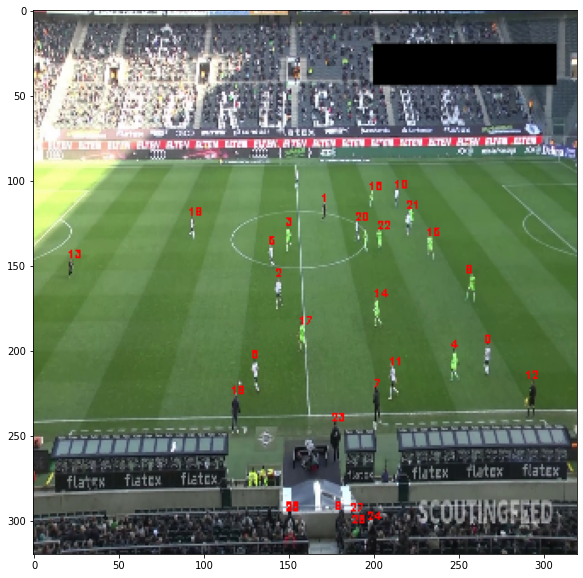

In [18]:
plt.figure(figsize=(20, 10))
plt.imshow(points_field_image)
plt.show()